In [231]:
import re
from lifelines import CoxPHFitter
from multipy.fdr import lsu
def CoxRegression(FeatureUseDf,FeatureALL,event_col,OS_col,
                  WithEdema=False,DfOnly=False,
                  Scaler=None,MultiVarCoxOnly=True,FilePath_Prefix=None,FDR=False):
    

    if Scaler=='MinMaxScaler':
        from sklearn.preprocessing import MinMaxScaler
        ScalerUse=MinMaxScaler()
    elif Scaler=='StandardScaler':
        from sklearn.preprocessing import StandardScaler
        ScalerUse=StandardScaler()
    else:
        ScalerUse=None
    Result={}
    for g in ['EGFR','ALK','KRAS']:
        Features=list(FeatureUseDf.loc[0:20,g+'_Survival'])
        FeatureUse=[x.replace('shape_','') for x in Features]
        Df=FeatureALL.loc[FeatureALL.loc[:,g]==1,[event_col,OS_col]+FeatureUse]
#         return Df
        Df['vols_T1c_mm3']=Df['vols_T1c_mm3']/Df['TumorNumber']
        Df['vols_T2Flair_mm3']=Df['vols_T2Flair_mm3']/Df['TumorNumber']-Df['vols_T1c_mm3']
#         Df['vols_T2Flair_mm3']=Df['vols_T2Flair_mm3']/Df['TumorNumber']
        Df['Edema_Tumor_Ratio']=Df['vols_T2Flair_mm3']/Df['vols_T1c_mm3']
        Df.rename(columns={'vols_T2Flair_mm3':'EdemaSize','vols_T1c_mm3':'TumorSize'},inplace=True)
#         Df.drop('vols_T2Flair_mm3',axis=1,inplace=True)
        try:
            Df.iloc[:,2:]=ScalerUse.fit_transform(Df.iloc[:,2:])
        except:
            print 'No scaler'
            pass
        if WithEdema:
            pass
        else:
            Df=Df.drop('EdemaSize',axis=1)
        DfOut=pd.merge(FeatureALL.loc[:,['ChenLabID',event_col,OS_col]],Df,
                        on=[event_col,OS_col]).drop_duplicates(Df.columns)
        if DfOnly:
            Result[g]=DfOut
        else:
            if MultiVarCoxOnly:
                cph = CoxPHFitter()
                MultiVarCox=cph.fit(Df, duration_col=OS_col, event_col=event_col, show_progress=False)
                ResultDfList=[('BasedData',DfOut),('MultiVarCoxOnly',MultiVarCox.summary)]
                Result[g]=dict(ResultDfList)
            else:
                temp=[]
                for f in range(2,len(Df.columns)):
                    cph = CoxPHFitter()
                    temp.append(cph.fit(Df.iloc[:,[0,1]+[f]], 
                                         duration_col=OS_col, event_col=event_col, 
                                         show_progress=False).summary)
                UnivariateCox=pd.concat(temp)
                if FDR:
                    from multipy.fdr import lsu
                    significant_pvals = lsu(UnivariateCox.p, q=0.05)
                else:
                    significant_pvals=UnivariateCox.p<0.05
                SigFeatures=list(UnivariateCox.index[significant_pvals])
                cph = CoxPHFitter()
                MultivariateCox=cph.fit(Df.loc[:,SigFeatures+[event_col,OS_col]], duration_col=OS_col, event_col=event_col, show_progress=False)
                ResultDfList=[('BasedData',DfOut),('UnivariateCox',UnivariateCox),('MultivariateCox',MultivariateCox.summary)]
                Result[g]=dict(ResultDfList)
            if FilePath_Prefix!=None:
                for x,d in ResultDfList:
                    d.to_csv('_'.join([FilePath_Prefix,g,x+'.csv']))
            else:
                pass

        #         cph.print_summary()  # access the results using cph.summary
        #         Result=cph.summary
    return Result

In [2]:
import pandas as pd
RadiomicFeatureVolSurvival=pd.read_excel('./RadiomicFeatureVolSurvival.xlsx')
Feature_selected_updated=pd.read_excel('./RadiomicFeatureUse_updated.xlsx')

In [274]:
Df=RadiomicFeatureVolSurvival.loc[:,['ChenLabID','EGFR','ALK','KRAS','vols_T1c_mm3','vols_T2Flair_mm3','TumorNumber']]

In [275]:
Df['vols_T1c_mm3']=Df['vols_T1c_mm3']/Df['TumorNumber']
Df['vols_T2Flair_mm3']=Df['vols_T2Flair_mm3']/Df['TumorNumber']-Df['vols_T1c_mm3']
Df['Edema_Tumor_Ratio']=Df['vols_T2Flair_mm3']/Df['vols_T1c_mm3']
Df.rename(columns={'vols_T2Flair_mm3':'EdemaSize','vols_T1c_mm3':'TumorSize'},inplace=True)

In [276]:
DfUse=Df.drop_duplicates()

In [277]:
Df[(Df.EGFR+Df.KRAS+Df.ALK)>1].drop_duplicates()

,ChenLabID,EGFR,ALK,KRAS,TumorSize,EdemaSize,TumorNumber,Edema_Tumor_Ratio
47,SalgiaGroupID_032,1,1,0,165.668892,3.773608,12,0.022778
114,SalgiaGroupID_063,1,1,0,285.787819,985.947470,27,3.449928
218,SalgiaGroupID_128,0,1,1,19128.591400,36431.616500,1,1.904563
286,SalgiaGroupID_030,1,1,0,104.440391,128.309618,11,1.228544
300,SalgiaGroupID_041,0,1,1,13179.400050,76097.868000,2,5.774001
341,SalgiaGroupID_060,1,1,0,3321.741913,9817.888175,8,2.955644


In [286]:
Mutation=pd.DataFrame(DfUse.loc[:,['ChenLabID','EGFR','ALK','KRAS']].set_index('ChenLabID').stack()).reset_index()

In [289]:
MutationUse=Mutation.loc[Mutation.loc[:,0]==1,['ChenLabID','level_1']].rename(columns={'level_1':'Mutation'})

In [290]:
MutationUse.head()

,ChenLabID,Mutation
0,SalgiaGroupID_007,EGFR
3,SalgiaGroupID_009,EGFR
7,SalgiaGroupID_010,ALK
9,SalgiaGroupID_011,EGFR
12,SalgiaGroupID_015,EGFR


In [292]:
TumorInfom=pd.merge(MutationUse,DfUse.drop(['EGFR','ALK','KRAS'],axis=1),on='ChenLabID')

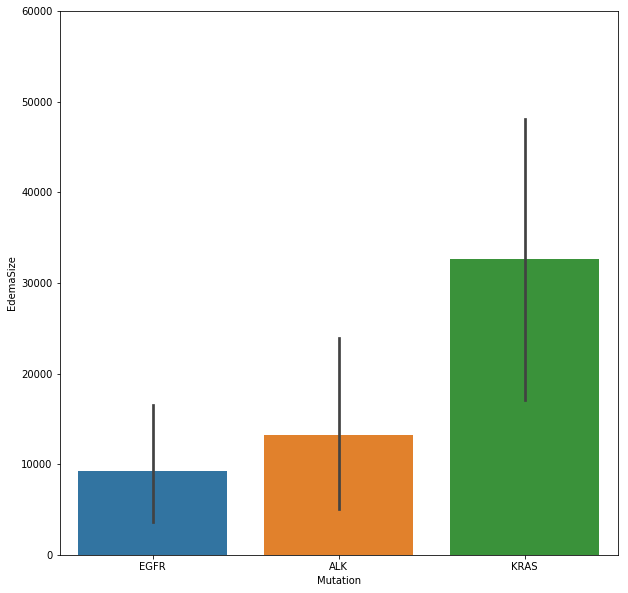

In [300]:
plt.figure(figsize=(10,10))
sns.barplot(x='Mutation', y='EdemaSize', data=TumorInfom)

plt.ylim(ymax=60000)
plt.show()

In [304]:
TumorInfom.loc[:,f].max()

227700.48859999998

In [306]:
St.pvalue

0.5625497979806113

EdemaSize


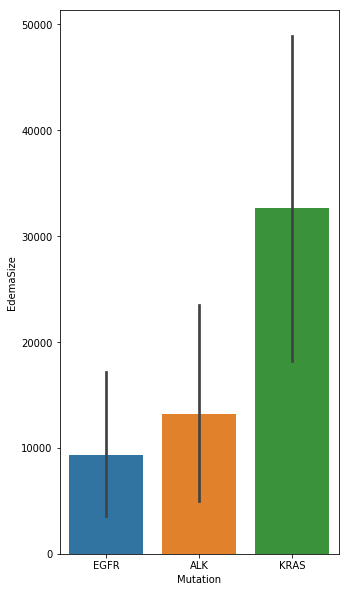

TumorSize


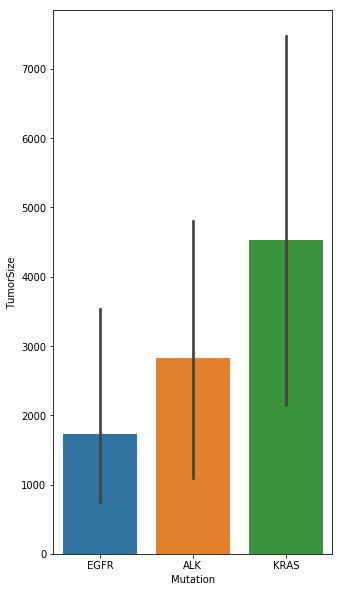

TumorNumber


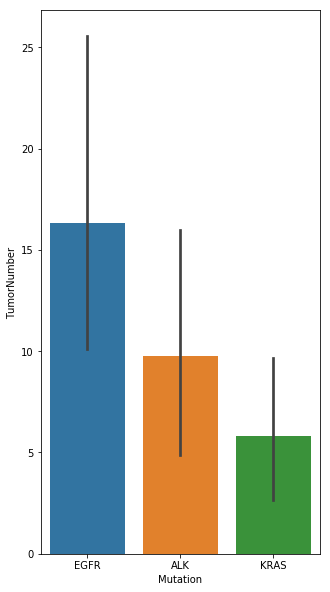

Edema_Tumor_Ratio


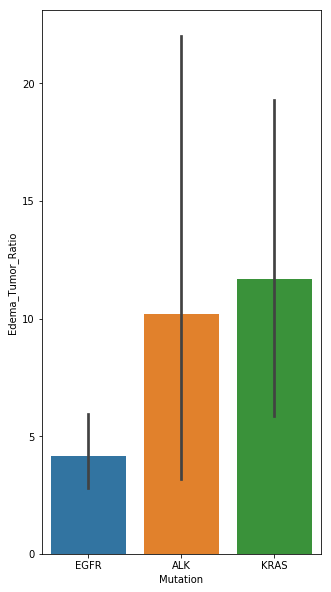

In [314]:
from scipy import stats
from itertools import combinations
ResultDict={}
for f in ['EdemaSize','TumorSize','TumorNumber','Edema_Tumor_Ratio']:
    print f
    plt.figure(figsize=(5,10))
    sns.barplot(x='Mutation', y=f, data=TumorInfom)
    plt.show()
    for g1,g2 in combinations(['EGFR','ALK','KRAS'],2):
        St=stats.ttest_ind(TumorInfom.loc[TumorInfom.Mutation==g1,f],TumorInfom.loc[TumorInfom.Mutation==g2,f])
        ResultDict.setdefault(f,{}).update({'_'.join((g1,g2)):St.pvalue})

In [316]:
pd.DataFrame(ResultDict).T.round(3).to_excel('./TumorInforResult.xlsx')

In [209]:
ResultDf=CoxRegression(event_col='VitalStatus',OS_col='survivalDuration_img',DfOnly=True,
                      FeatureALL=RadiomicFeatureVolSurvival, FeatureUseDf=Feature_selected_updated)


No scaler
No scaler
No scaler


In [211]:
ResultDf['EGFR'].head()

,ChenLabID,VitalStatus,survivalDuration_img,TumorSize,TumorNumber,2DT2_FLAIR_Edema_logarithm_glcm_JointEnergy,2DT2_FLAIR_Edema_square_gldm_LargeDependenceHighGrayLevelEmphasis,2DT2_FLAIR_Edema_squareroot_glszm_LargeAreaLowGrayLevelEmphasis,2DT2_FLAIR_Edema_wavelet-HH_firstorder_InterquartileRange,2DT1C_Tumor_squareroot_firstorder_InterquartileRange,...,2DT2_FLAIR_Edema_squareroot_glrlm_LongRunLowGrayLevelEmphasis,2DT2_FLAIR_Edema_gradient_firstorder_Kurtosis,2DT1C_Tumor_squareroot_gldm_LargeDependenceLowGrayLevelEmphasis,2DT2_FLAIR_Edema_log-sigma-1-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis,2DT1C_Tumor_log-sigma-2-mm-3D_gldm_DependenceNonUniformity,2DT2_FLAIR_Edema_logarithm_glszm_LargeAreaHighGrayLevelEmphasis,2DT2_FLAIR_Edema_log-sigma-3-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis,2DT1C_Tumor_gradient_ngtdm_Coarseness,2DT2_FLAIR_Edema_log-sigma-2-mm-3D_ngtdm_Contrast,Edema_Tumor_Ratio
0,SalgiaGroupID_007,0,2715,1030.010950,2,0.120072,989.597468,17.445912,6.870086,19.428857,...,0.524099,3.721020,52.960216,159.429563,10.591837,3452.000000,64.913801,0.128913,0.027412,-0.268
1,SalgiaGroupID_007,0,2715,1030.010950,2,0.182717,1441.639066,4.957831,6.728512,24.048953,...,0.298264,3.375278,11.828087,104.893275,7.929936,4389.700000,93.941849,0.057487,0.038386,-0.268
4,SalgiaGroupID_009,1,61,69.848436,39,0.142607,1280.558442,6.840104,1.142961,32.385893,...,0.204142,3.119866,19.462848,569.230159,9.909091,39330.444444,959.117965,0.040171,0.033793,-1.000
5,SalgiaGroupID_009,1,61,69.848436,39,0.316055,652.583333,39.148148,0.591162,13.289501,...,1.670176,3.337107,193.690972,196.312500,4.750000,883.285714,419.107639,0.095528,0.071738,-1.000
6,SalgiaGroupID_009,1,61,69.848436,39,0.299848,945.779661,252.673611,0.266685,16.572190,...,4.622639,7.993810,73.012065,715.833333,5.305085,5428.166667,596.843220,0.067426,0.025936,-1.000


In [66]:
RadiomicFeatureVolSurvival.drop_duplicates('ChenLabID').ALK.value_counts()

0    84
1    26
Name: ALK, dtype: int64

In [236]:
Result1=CoxRegression(event_col='VitalStatus',OS_col='survivalDuration_img',Scaler='MinMaxScaler',FilePath_Prefix='./MultiCox',
                      FeatureALL=RadiomicFeatureVolSurvival, FeatureUseDf=Feature_selected_updated)
                     

In [237]:
Result2=CoxRegression(event_col='VitalStatus',OS_col='survivalDuration_img',Scaler='MinMaxScaler',FDR=True,
                      MultiVarCoxOnly=False,FilePath_Prefix='./UniCox',
                      FeatureALL=RadiomicFeatureVolSurvival, FeatureUseDf=Feature_selected_updated)

In [216]:
Result2.keys()

['EGFR', 'ALK', 'KRAS']

In [238]:
Result2['EGFR']['MultivariateCox'].shape

(12, 7)

In [239]:
Result2['EGFR']['MultivariateCox'].p<0.05

TumorNumber                                                                True
2DT2_FLAIR_Edema_logarithm_glcm_JointEnergy                                True
2DT2_FLAIR_Edema_square_gldm_LargeDependenceHighGrayLevelEmphasis         False
2DT2_FLAIR_Edema_squareroot_glszm_LargeAreaLowGrayLevelEmphasis           False
2DT2_FLAIR_Edema_wavelet-HH_firstorder_InterquartileRange                  True
2DT2_FLAIR_Edema_wavelet-LH_glszm_SizeZoneNonUniformityNormalized          True
2DT2_FLAIR_Edema_square_glrlm_LongRunEmphasis                             False
2DT2_FLAIR_Edema_squareroot_glrlm_LongRunLowGrayLevelEmphasis             False
2DT2_FLAIR_Edema_gradient_firstorder_Kurtosis                             False
2DT2_FLAIR_Edema_log-sigma-1-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis    False
2DT1C_Tumor_log-sigma-2-mm-3D_gldm_DependenceNonUniformity                False
Edema_Tumor_Ratio                                                          True
Name: p, dtype: bool

In [240]:
Result2['ALK']['MultivariateCox'].p<0.05

TumorNumber                                                         True
2DT1C_Tumor_squareroot_gldm_LargeDependenceLowGrayLevelEmphasis    False
2DT1C_Tumor_logarithm_glrlm_HighGrayLevelRunEmphasis                True
2DT2_FLAIR_Edema_squareroot_glszm_LargeAreaLowGrayLevelEmphasis    False
Name: p, dtype: bool

In [241]:
Result2['KRAS']['MultivariateCox'].p<0.05

2DT2_FLAIR_Edema_log-sigma-2-mm-3D_ngtdm_Strength    True
Edema_Tumor_Ratio                                    True
Name: p, dtype: bool

# Index

In [40]:
ALK_COXr=pd.read_csv('./ALK_Cox_multivariates_agv_ratio_sigOnly.tsv',sep='\t',index_col=0)
ALK_COXd=pd.read_csv('./ALK_Cox_multivariates_agv_ratio_sigOnly_scaledFeatures.tsv',sep='\t',index_col=0)

In [154]:
def HazardRate(Cox_d,Cox_r,event_col='VitalStatus',OS_col='survivalDuration_img',other_col='Edema_Tumor_Ratio',p_limit=None,):
    '''other_col is for make sure we separate different patient'''
    if p_limit==None:
        Cox_rUse=Cox_r    
    else:
        Cox_rUse=Cox_r.loc[Cox_r.p<p_limit,:]
 
    temp=Cox_d.loc[:,list(Cox_rUse.index)]*Cox_rUse.coef
    Cox_d['HR']=temp.sum(axis=1)
    HRmean=Cox_d.loc[:,[event_col,OS_col,other_col,'HR']].groupby([event_col,OS_col,other_col]).mean()
    DfUse=Cox_d.loc[:,[event_col,OS_col,'HR']+list(Cox_rUse.index)]
    HRmeanUse=HRmean.reset_index().drop(other_col,axis=1)
    return {'HRDf':HRmeanUse,'SignificantFeatureValues':DfUse}

In [317]:
temp=HazardRate(Cox_d=ALK_COXd,Cox_r=ALK_COXr,p_limit=0.05)

In [318]:
temp.keys()

['SignificantFeatureValues', 'HRDf']

In [182]:
from scipy import stats
import seaborn as sns
def SigHeatmap(SigDf,MaxMin=None,zscore=True):
    if zscore:
        temp=SigDf.sort_values('HR').iloc[:,3:]
        tempUse=pd.DataFrame(stats.zscore(temp, axis=1, ddof=1))
        tempUse.index=temp.index
        tempUse.columns=temp.columns
    else:
        tempUse=SigDf.sort_values('HR').iloc[:,3:]
    if MaxMin!=None:
        Max,Min=MaxMin
        sns.heatmap(tempUse.T,
                    cmap=sns.color_palette("Blues"),
                    vmax=Max,vmin=Min)
    else:
        sns.heatmap(tempUse.T,
                    cmap=sns.color_palette("Blues"))
    plt.show()


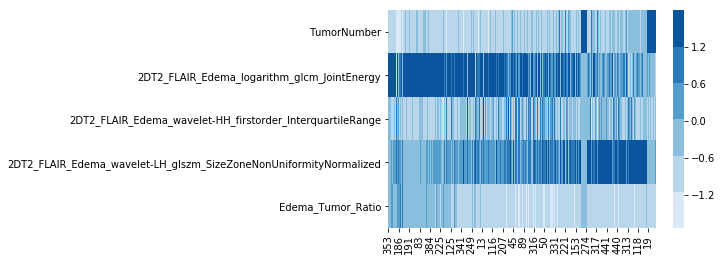

In [183]:
SigHeatmap(SigDf=Result3['EGFR']['SignificantFeatureValues'])

In [152]:
from lifelines import KaplanMeierFitter

import matplotlib.pyplot as plt
def GroupKM(HRDf,CutValue,event_col='VitalStatus',OS_col='survivalDuration_img'):
    ix = HRDf.HR<CutValue
    kmf = KaplanMeierFitter()
    kmf.fit(HRDf.loc[ix,OS_col], HRDf.loc[ix,event_col], label='Low Hazard Rate group')
    ax = kmf.plot(ci_show=False,show_censors=True)

    kmf.fit(HRDf.loc[~ix,OS_col], HRDf.loc[~ix,event_col], label='High Hazard Rate group')
    kmf.plot(ax=ax,ci_show=False,show_censors=True)
    plt.show()


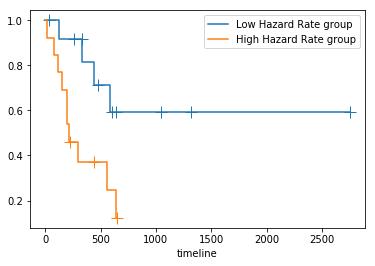

In [155]:
GroupKM(HRDf=a['HRDf'],CutValue=a['HRDf'].HR.median())

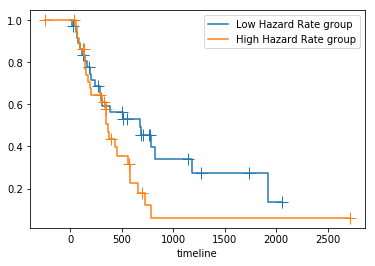

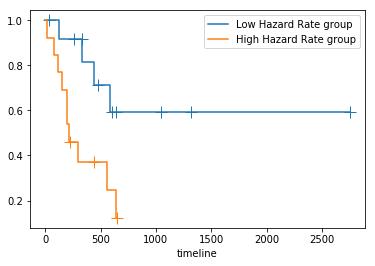

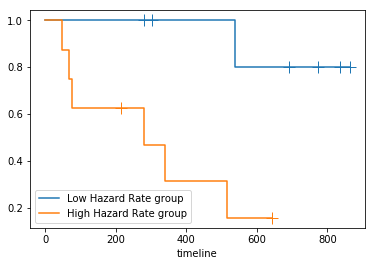

In [320]:
Result3={}
for i in ['EGFR','ALK','KRAS']:
    Cox_r=pd.read_csv('./'+i+'_Cox_multivariates_agv_ratio_sigOnly.tsv',sep='\t',index_col=0)
    Cox_d=pd.read_csv('./'+i+'_Cox_multivariates_agv_ratio_sigOnly_scaledFeatures.tsv',sep='\t',index_col=0)
    temp=HazardRate(Cox_d=Cox_d,Cox_r=Cox_r)
    Result3[i]=temp
    HRDf=temp['HRDf']
#     Sig=temp['SignificantFeatureValues']
    GroupKM(HRDf=HRDf,CutValue=HRDf.HR.median())
#     SigHeatmap(SigDf=temp['SignificantFeatureValues'])

EGFR


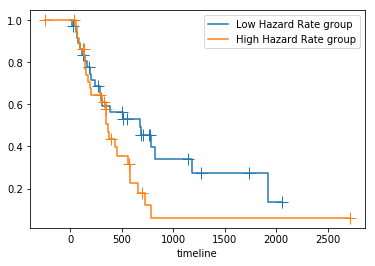

ALK


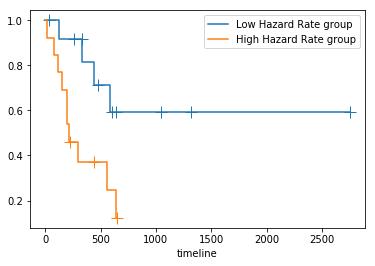

KRAS


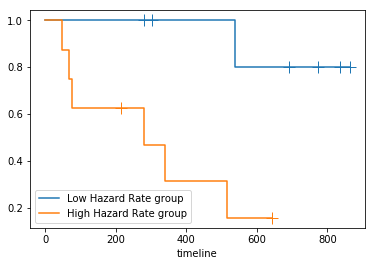

In [321]:
Result3={}
for i in ['EGFR','ALK','KRAS']:
    print i
    Cox_r=pd.read_csv('./'+i+'_Cox_multivariates_agv_ratio_sigOnly.tsv',sep='\t',index_col=0)
    Cox_d=pd.read_csv('./'+i+'_Cox_multivariates_agv_ratio_sigOnly_scaledFeatures.tsv',sep='\t',index_col=0)
    temp=HazardRate(Cox_d=Cox_d,Cox_r=Cox_r,p_limit=0.05)
    Result3[i]=temp
    HRDf=temp['HRDf']
#     Sig=temp['SignificantFeatureValues']
    GroupKM(HRDf=HRDf,CutValue=HRDf.HR.median())
#     SigHeatmap(SigDf=temp['SignificantFeatureValues'])


EGFR


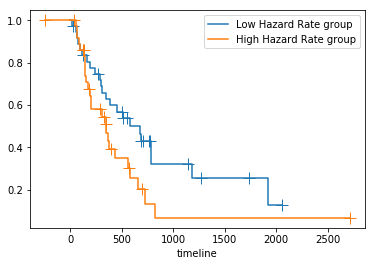

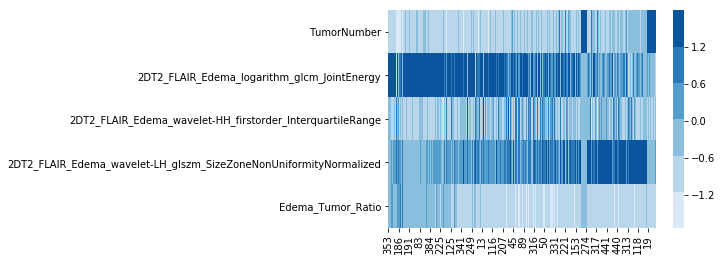

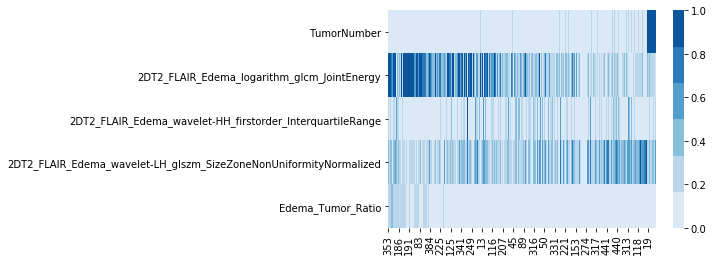

ALK


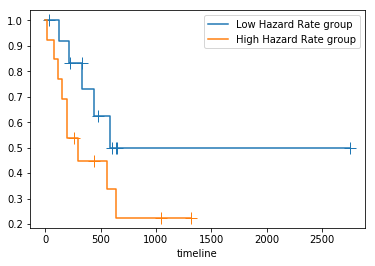

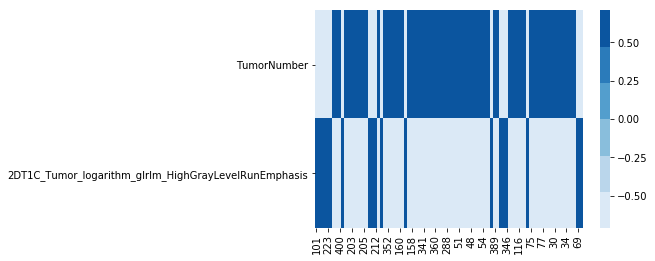

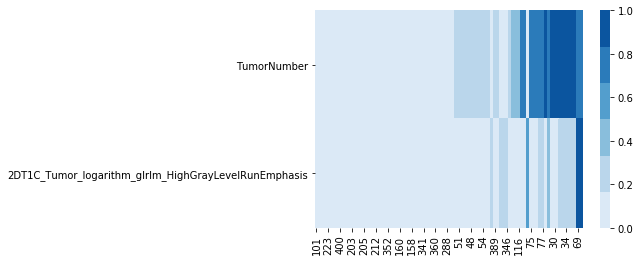

KRAS


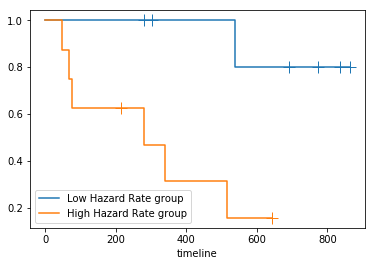

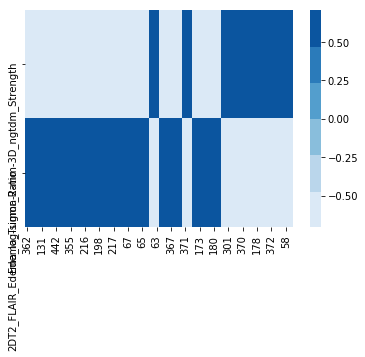

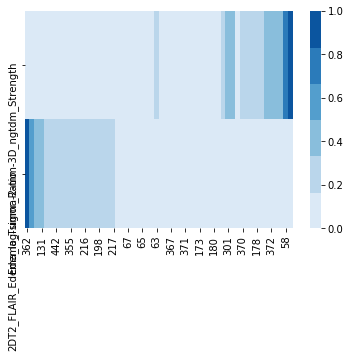

In [184]:
Result3={}
for i in Result2.keys():
    print i
    Cox_r=Result2[i]['MultivariateCox']
    Cox_d=Result2[i]['BasedData']
    temp=HazardRate(Cox_d=Cox_d,Cox_r=Cox_r,p_limit=0.05)
    Result3[i]=temp
    HRDf=temp['HRDf']
#     Sig=temp['SignificantFeatureValues']
    GroupKM(HRDf=HRDf,CutValue=HRDf.HR.median())
    SigHeatmap(SigDf=temp['SignificantFeatureValues'])
    SigHeatmap(SigDf=temp['SignificantFeatureValues'],zscore=False)
#     sns.heatmap(Sig.sort_values('HR').iloc[:,3:].T,cmap=sns.color_palette("RdBu_r", 7))
#     plt.show()

In [ ]:
Result3

In [124]:
b.sort_values('HR').iloc[:,3:].median()

Edema_Tumor_Ratio                                                 -0.043563
TumorNumber                                                       -0.161728
2DT1C_Tumor_wavelet-LH_gldm_SmallDependenceEmphasis               -0.049783
2DT1C_Tumor_log-sigma-1-mm-3D_glrlm_LongRunLowGrayLevelEmphasis   -0.082217
2DT1C_Tumor_logarithm_glrlm_HighGrayLevelRunEmphasis              -0.075829
2DT2_FLAIR_Edema_square_glrlm_LongRunLowGrayLevelEmphasis         -0.056936
dtype: float64